## Mu Cheng Project 4 

In [1]:
%matplotlib inline

## Task 1. MNIST Tutorial

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt


### Dataset

In [3]:
# Download training data from open datasets.
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [4]:
training_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [5]:
len(training_data)

60000

In [6]:
len(training_data[0])

2

In [7]:
training_data[0][0].shape,training_data[0][1]

(torch.Size([1, 28, 28]), 5)

### Dataloader


In [8]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)


In [9]:

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


### Check device

In [10]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")


Using cpu device


## Building a CNN Model for MNIST Dataset




In [11]:
import torch.nn as nn
import torch.nn.functional as F

class NetMnist(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.flatten(x) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model_cnn_mnist = NetMnist().to(device)
model_cnn_mnist(X).shape

torch.Size([64, 10])

In [16]:
model_cnn_mnist

NetMnist(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

### Calculating Loss and Add an Optimizer


In [12]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_cnn_mnist.parameters(), lr=1e-3)

### Training and Testing Loops


In [13]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [14]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return correct,test_loss

### Train and Test the Model



In [15]:
epochs = 2
train_correct_list = []
train_loss_list = []
test_correct_list = []
test_loss_list = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model_cnn_mnist, loss_fn, optimizer)
    train_correct,train_loss = test(train_dataloader, model_cnn_mnist, loss_fn)
    test_correct,test_loss = test(test_dataloader, model_cnn_mnist, loss_fn)
    train_correct_list.append(train_correct)
    train_loss_list.append(train_loss)
    test_correct_list.append(test_correct)
    test_loss_list.append(test_loss)
print("Done!")

Epoch 1
-------------------------------
loss: 2.308596  [    0/60000]
loss: 0.536761  [ 6400/60000]
loss: 0.245681  [12800/60000]
loss: 0.278733  [19200/60000]
loss: 0.204449  [25600/60000]
loss: 0.134031  [32000/60000]
loss: 0.153969  [38400/60000]
loss: 0.199176  [44800/60000]
loss: 0.318619  [51200/60000]
loss: 0.134764  [57600/60000]
Test Error: 
 Accuracy: 96.2%, Avg loss: 0.121534 

Test Error: 
 Accuracy: 96.7%, Avg loss: 0.105275 

Epoch 2
-------------------------------
loss: 0.067158  [    0/60000]
loss: 0.098950  [ 6400/60000]
loss: 0.082568  [12800/60000]
loss: 0.181152  [19200/60000]
loss: 0.049283  [25600/60000]
loss: 0.058418  [32000/60000]
loss: 0.120235  [38400/60000]
loss: 0.118087  [44800/60000]
loss: 0.195009  [51200/60000]
loss: 0.117735  [57600/60000]
Test Error: 
 Accuracy: 97.3%, Avg loss: 0.084915 

Test Error: 
 Accuracy: 97.6%, Avg loss: 0.078065 

Done!


In [19]:
## Save the model
torch.save(model_cnn_mnist.state_dict(), "model_cnn_mnist.pth")
print("Saved PyTorch Model State to model_cnn_mnist.pth")

Saved PyTorch Model State to model_cnn_mnist.pth


In [20]:
model_cnn_mnist_load = NetMnist().to(device)
model_cnn_mnist_load.load_state_dict(torch.load("model_cnn_mnist.pth"))

<All keys matched successfully>

## Prediction 

In [21]:
classes = [
    "0",
    "1",
    "2",
    "3",
    "4",
    "5",
    "6",
    "7",
    "8",
    "9",
]

Predicted: "7", Actual: "7"


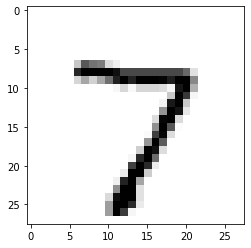

Predicted: "2", Actual: "2"


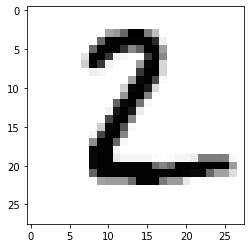

Predicted: "1", Actual: "1"


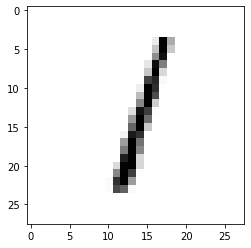

Predicted: "0", Actual: "0"


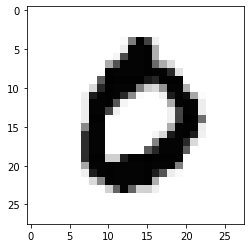

Predicted: "4", Actual: "4"


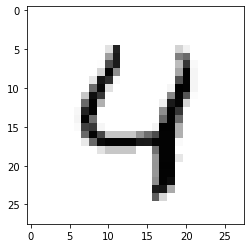

Predicted: "1", Actual: "1"


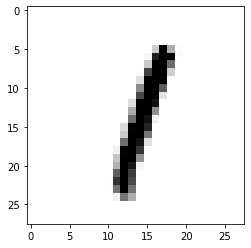

Predicted: "4", Actual: "4"


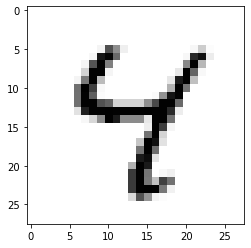

Predicted: "9", Actual: "9"


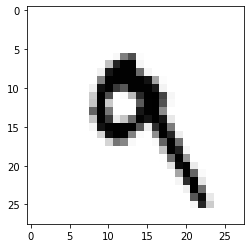

Predicted: "5", Actual: "5"


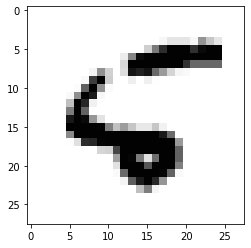

In [22]:
model_cnn_mnist_load.eval()
for i in range(9):
    x,y = test_data[i][0], test_data[i][1]
    with torch.no_grad():
        pred = model_cnn_mnist_load(x.unsqueeze(0))
        predicted, actual = classes[pred[0].argmax(0)], classes[y]
        print(f'Predicted: "{predicted}", Actual: "{actual}"')
        one_img = test_data[i][0].numpy()
        plt.imshow(one_img.squeeze(), cmap='Greys')
        plt.show()

### Model Evaluations of Errors in Training and Testing Datasets

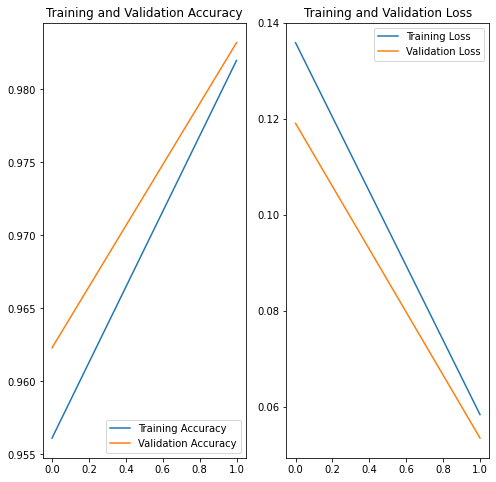

In [16]:
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_correct_list, label='Training Accuracy')
plt.plot(epochs_range, test_correct_list, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss_list, label='Training Loss')
plt.plot(epochs_range, test_loss_list, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Task 2. Experiment with Network Variations Using Fashion MNIST Dataset

In [26]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

import torchvision
import torchvision.transforms as transforms

In [27]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [28]:
training_data

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [29]:
len(training_data)

60000

In [30]:
len(training_data[0])

2

In [31]:
training_data[0][0].shape,training_data[0][1]

(torch.Size([1, 28, 28]), 9)

In [32]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)


In [33]:

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


In [34]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")


Using cpu device


### Building the CNN Model for FashionMNIST Dataset




In [35]:
## Base Model
import torch.nn as nn
import torch.nn.functional as F


class NetFMnist(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.flatten(x) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model_cnn_fmnist = NetFMnist().to(device)
model_cnn_fmnist(X).shape

torch.Size([64, 10])

In [37]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_cnn_fmnist.parameters(), lr=1e-3)

In [38]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [39]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return correct,test_loss

### Train and Test the Datasets



In [40]:
epochs = 2
train_correct_list = []
train_loss_list = []
test_correct_list = []
test_loss_list = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model_cnn_fmnist, loss_fn, optimizer)
    train_correct,train_loss = test(train_dataloader, model_cnn_fmnist, loss_fn)
    test_correct,test_loss = test(test_dataloader, model_cnn_fmnist, loss_fn)
    train_correct_list.append(train_correct)
    train_loss_list.append(train_loss)
    test_correct_list.append(test_correct)
    test_loss_list.append(test_loss)
print("Done!")

Epoch 1
-------------------------------
loss: 2.297807  [    0/60000]
loss: 0.804556  [ 6400/60000]
loss: 0.542692  [12800/60000]
loss: 0.660558  [19200/60000]
loss: 0.597033  [25600/60000]
loss: 0.527567  [32000/60000]
loss: 0.517664  [38400/60000]
loss: 0.560075  [44800/60000]
loss: 0.505921  [51200/60000]
loss: 0.482324  [57600/60000]
Test Error: 
 Accuracy: 80.5%, Avg loss: 0.502820 

Test Error: 
 Accuracy: 79.9%, Avg loss: 0.522964 

Epoch 2
-------------------------------
loss: 0.407637  [    0/60000]
loss: 0.485252  [ 6400/60000]
loss: 0.304722  [12800/60000]
loss: 0.449496  [19200/60000]
loss: 0.433872  [25600/60000]
loss: 0.460895  [32000/60000]
loss: 0.361870  [38400/60000]
loss: 0.581208  [44800/60000]
loss: 0.471796  [51200/60000]
loss: 0.386593  [57600/60000]
Test Error: 
 Accuracy: 84.7%, Avg loss: 0.412346 

Test Error: 
 Accuracy: 83.9%, Avg loss: 0.441850 

Done!


In [49]:
## Save the Model
torch.save(model_cnn_fmnist.state_dict(), "model_cnn_fmnist.pth")
print("Saved PyTorch Model State to model_cnn_fmnist.pth")

Saved PyTorch Model State to model_cnn_fmnist.pth


In [53]:
## Load the Model
model_cnn_fmnist_load = NetFMnist().to(device)
model_cnn_fmnist_load.load_state_dict(torch.load("model_cnn_fmnist.pth"))

<All keys matched successfully>

### Predictions

In [54]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]


Predicted: "Sandal", Actual: "Ankle boot"


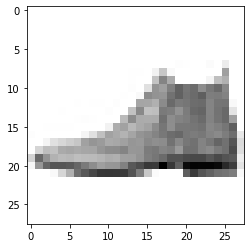

Predicted: "Sandal", Actual: "Pullover"


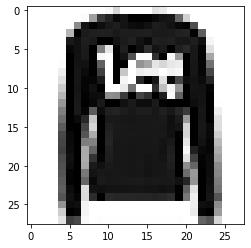

Predicted: "Sandal", Actual: "Trouser"


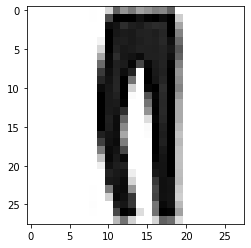

Predicted: "Sandal", Actual: "Trouser"


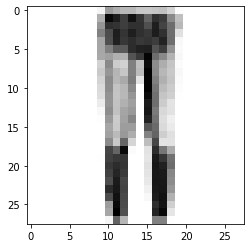

Predicted: "Sandal", Actual: "Shirt"


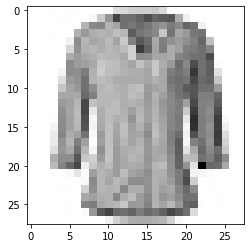

Predicted: "Sandal", Actual: "Trouser"


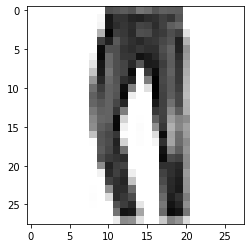

Predicted: "Sandal", Actual: "Coat"


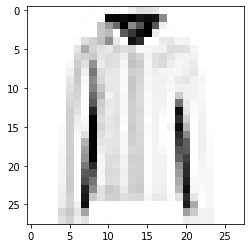

Predicted: "Sandal", Actual: "Shirt"


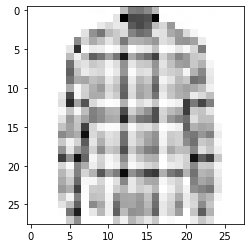

Predicted: "Sandal", Actual: "Sandal"


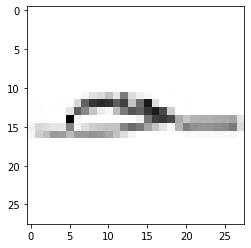

In [55]:
model_cnn_fmnist_load.eval()
for i in range(9):
    x,y = test_data[i][0], test_data[i][1]
    with torch.no_grad():
        pred = model_cnn_fmnist_load(x.unsqueeze(0))
        predicted, actual = classes[pred[0].argmax(0)], classes[y]
        print(f'Predicted: "{predicted}", Actual: "{actual}"')
        one_img = test_data[i][0].numpy()
        plt.imshow(one_img.squeeze(), cmap='Greys')
        plt.show()

### Model Evaluations of Errors in Training and Testing Datasets

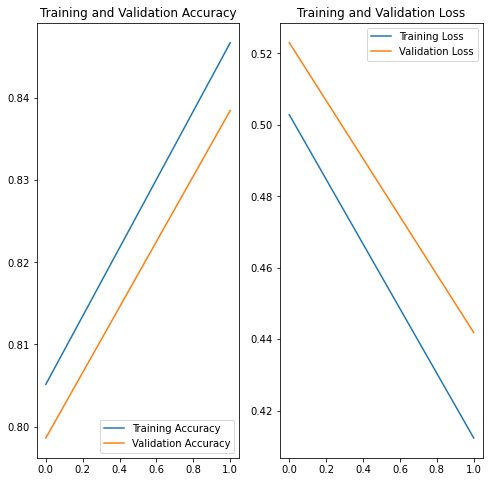

In [56]:
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_correct_list, label='Training Accuracy')
plt.plot(epochs_range, test_correct_list, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss_list, label='Training Loss')
plt.plot(epochs_range, test_loss_list, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Change Dimension #1. Change the Kernel Size 
Hypothesis:\
Change from 5 to 3 will help increase the accuracy 

Actual: \
Accuracy score is slightly increased from previous results Accuracy: 83.9%, Avg loss: 0.441850  to current results 
Accuracy: 84.0%, Avg loss: 0.426858 

In [57]:
## model 1

import torch.nn as nn
import torch.nn.functional as F


class KS_NetFMnist(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(400, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.flatten(x) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


ks_model_cnn_fmnist = KS_NetFMnist().to(device)
ks_model_cnn_fmnist(X).shape

torch.Size([64, 10])

In [58]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(ks_model_cnn_fmnist.parameters(), lr=1e-3)

In [59]:
epochs = 2
train_correct_list = []
train_loss_list = []
test_correct_list = []
test_loss_list = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, ks_model_cnn_fmnist, loss_fn, optimizer)
    train_correct,train_loss = test(train_dataloader, model_cnn_fmnist, loss_fn)
    test_correct,test_loss = test(test_dataloader, ks_model_cnn_fmnist, loss_fn)
    train_correct_list.append(train_correct)
    train_loss_list.append(train_loss)
    test_correct_list.append(test_correct)
    test_loss_list.append(test_loss)
print("Done!")

Epoch 1
-------------------------------
loss: 2.296419  [    0/60000]
loss: 0.863862  [ 6400/60000]
loss: 0.537875  [12800/60000]
loss: 0.638487  [19200/60000]
loss: 0.584512  [25600/60000]
loss: 0.457290  [32000/60000]
loss: 0.568238  [38400/60000]
loss: 0.596875  [44800/60000]
loss: 0.545144  [51200/60000]
loss: 0.498018  [57600/60000]
Test Error: 
 Accuracy: 10.0%, Avg loss: 2.306530 

Test Error: 
 Accuracy: 81.3%, Avg loss: 0.487543 

Epoch 2
-------------------------------
loss: 0.389515  [    0/60000]
loss: 0.489384  [ 6400/60000]
loss: 0.296136  [12800/60000]
loss: 0.568976  [19200/60000]
loss: 0.404034  [25600/60000]
loss: 0.423941  [32000/60000]
loss: 0.407137  [38400/60000]
loss: 0.574204  [44800/60000]
loss: 0.529516  [51200/60000]
loss: 0.452230  [57600/60000]
Test Error: 
 Accuracy: 10.0%, Avg loss: 2.306530 

Test Error: 
 Accuracy: 84.0%, Avg loss: 0.426858 

Done!


### Variation Model Evaluations of Errors in Training and Testing Datasets

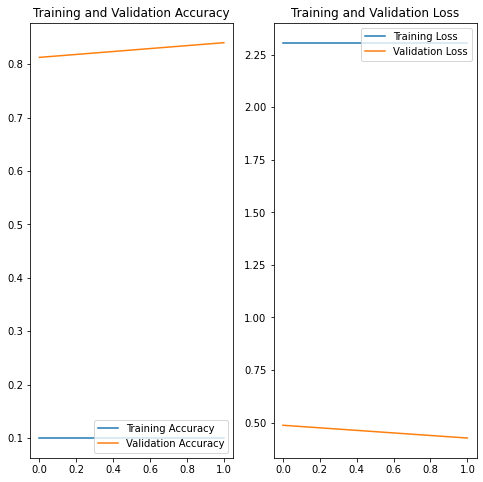

In [60]:
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_correct_list, label='Training Accuracy')
plt.plot(epochs_range, test_correct_list, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss_list, label='Training Loss')
plt.plot(epochs_range, test_loss_list, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Change Dimension #2. Add a Dropout Layer
Hypothesis:\
Adding a dropout layer before the final fully connected layer will help increase the accuracy 

Actual: \
Accuracy score is slightly decreased from previous results Accuracy: 84.0%, Avg loss: 0.426858  to \
    
Accuracy: 83.8%, Avg loss: 0.434113 

In [61]:
## model 2

import torch.nn as nn
import torch.nn.functional as F


class add_dropout_NetFMnist(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(400, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.flatten(x) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x


add_dropout_model_cnn_fmnist = add_dropout_NetFMnist().to(device)
add_dropout_model_cnn_fmnist(X).shape

torch.Size([64, 10])

In [62]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(add_dropout_model_cnn_fmnist.parameters(), lr=1e-3)

In [63]:
epochs = 2
train_correct_list = []
train_loss_list = []
test_correct_list = []
test_loss_list = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, add_dropout_model_cnn_fmnist, loss_fn, optimizer)
    train_correct,train_loss = test(train_dataloader, add_dropout_model_cnn_fmnist, loss_fn)
    test_correct,test_loss = test(test_dataloader, add_dropout_model_cnn_fmnist, loss_fn)
    train_correct_list.append(train_correct)
    train_loss_list.append(train_loss)
    test_correct_list.append(test_correct)
    test_loss_list.append(test_loss)
print("Done!")

Epoch 1
-------------------------------
loss: 2.295181  [    0/60000]
loss: 1.127385  [ 6400/60000]
loss: 0.626881  [12800/60000]
loss: 0.744094  [19200/60000]
loss: 0.657285  [25600/60000]
loss: 0.559106  [32000/60000]
loss: 0.526337  [38400/60000]
loss: 0.662455  [44800/60000]
loss: 0.548008  [51200/60000]
loss: 0.540744  [57600/60000]
Test Error: 
 Accuracy: 80.6%, Avg loss: 0.500101 

Test Error: 
 Accuracy: 79.9%, Avg loss: 0.521592 

Epoch 2
-------------------------------
loss: 0.469125  [    0/60000]
loss: 0.557634  [ 6400/60000]
loss: 0.381037  [12800/60000]
loss: 0.516241  [19200/60000]
loss: 0.477711  [25600/60000]
loss: 0.549127  [32000/60000]
loss: 0.410473  [38400/60000]
loss: 0.574784  [44800/60000]
loss: 0.475968  [51200/60000]
loss: 0.388014  [57600/60000]
Test Error: 
 Accuracy: 84.6%, Avg loss: 0.407518 

Test Error: 
 Accuracy: 83.8%, Avg loss: 0.434113 

Done!


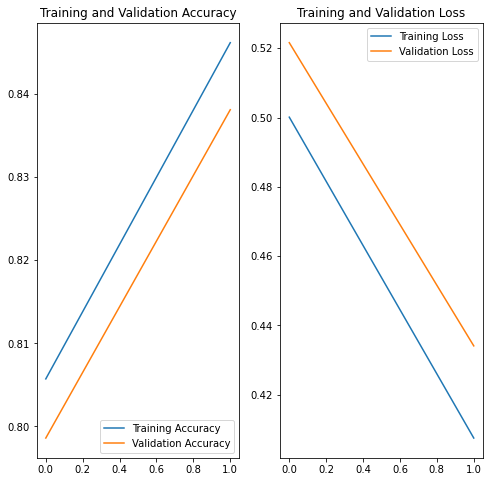

In [64]:
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_correct_list, label='Training Accuracy')
plt.plot(epochs_range, test_correct_list, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss_list, label='Training Loss')
plt.plot(epochs_range, test_loss_list, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Change Dimension #3. Change Learning Rate
Hypothesis:\
Lower the learning rate will help increase the accuracy 

Actual: \
Accuracy score is slightly decreased from previous results Accuracy: Accuracy: 83.8%, Avg loss: 0.434113 to current \
    
Accuracy: Accuracy: 85.2%, Avg loss: 0.397401 

In [65]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(add_dropout_model_cnn_fmnist.parameters(), lr=1e-4)

In [66]:
epochs = 2
train_correct_list = []
train_loss_list = []
test_correct_list = []
test_loss_list = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, add_dropout_model_cnn_fmnist, loss_fn, optimizer)
    train_correct,train_loss = test(train_dataloader, add_dropout_model_cnn_fmnist, loss_fn)
    test_correct,test_loss = test(test_dataloader, add_dropout_model_cnn_fmnist, loss_fn)
    train_correct_list.append(train_correct)
    train_loss_list.append(train_loss)
    test_correct_list.append(test_correct)
    test_loss_list.append(test_loss)
print("Done!")

Epoch 1
-------------------------------
loss: 0.316807  [    0/60000]
loss: 0.461393  [ 6400/60000]
loss: 0.302410  [12800/60000]
loss: 0.456135  [19200/60000]
loss: 0.333253  [25600/60000]
loss: 0.428844  [32000/60000]
loss: 0.373241  [38400/60000]
loss: 0.604943  [44800/60000]
loss: 0.459342  [51200/60000]
loss: 0.348453  [57600/60000]
Test Error: 
 Accuracy: 85.9%, Avg loss: 0.379248 

Test Error: 
 Accuracy: 84.7%, Avg loss: 0.404694 

Epoch 2
-------------------------------
loss: 0.271944  [    0/60000]
loss: 0.481477  [ 6400/60000]
loss: 0.283810  [12800/60000]
loss: 0.406784  [19200/60000]
loss: 0.356699  [25600/60000]
loss: 0.429559  [32000/60000]
loss: 0.357243  [38400/60000]
loss: 0.553306  [44800/60000]
loss: 0.466212  [51200/60000]
loss: 0.349710  [57600/60000]
Test Error: 
 Accuracy: 86.3%, Avg loss: 0.370337 

Test Error: 
 Accuracy: 85.2%, Avg loss: 0.397401 

Done!


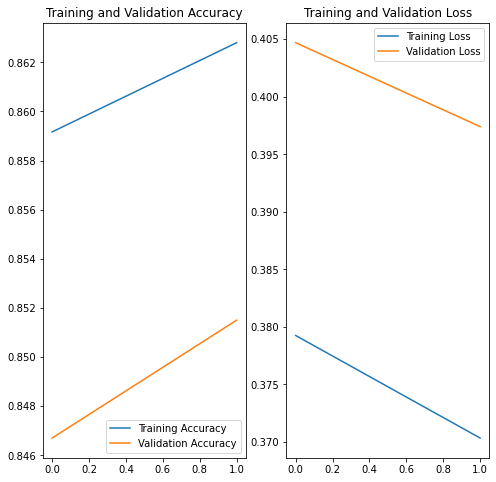

In [68]:
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_correct_list, label='Training Accuracy')
plt.plot(epochs_range, test_correct_list, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss_list, label='Training Loss')
plt.plot(epochs_range, test_loss_list, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Task 3. Transfer Learning on Greek Letters

In [73]:
!unzip /Users/mucheng/Desktop/greek_train.zip

Archive:  /Users/mucheng/Desktop/greek_train.zip
replace __MACOSX/._greek_train? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


## Reuse the Model Built for Task 1



In [77]:
import torch.nn as nn
import torch.nn.functional as F

model_cnn_greek = NetMnist().to(device)
# model_cnn_greek(X).shape

### Load the Model

In [78]:

model_cnn_greek.load_state_dict(torch.load("model_cnn_mnist.pth"))

<All keys matched successfully>

### Set requires_grad to False

In [79]:
for param in model_cnn_greek.parameters():
    param.requires_grad = False

### replace the last layer with a new Linear layer with three nodes

In [80]:
model_cnn_greek.fc3 = nn.Linear(84, 3)
model_cnn_greek

NetMnist(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=3, bias=True)
)

In [82]:
# greek data set transform
class GreekTransform:
    def __init__(self):
        pass

    def __call__(self, x):
        x = torchvision.transforms.functional.rgb_to_grayscale( x )
        x = torchvision.transforms.functional.affine( x, 0, (0,0), 36/128, 0 )
        x = torchvision.transforms.functional.center_crop( x, (28, 28) )
        return torchvision.transforms.functional.invert( x )

training_set_path = '/Users/mucheng/Desktop/greek_train'
# DataLoader for the Greek data set
greek_train = torch.utils.data.DataLoader(
    torchvision.datasets.ImageFolder( training_set_path,
                    transform = torchvision.transforms.Compose( [torchvision.transforms.ToTensor(),
                                            GreekTransform(),
                                            torchvision.transforms.Normalize((0.1307,), (0.3081,) )] ) ),
                    batch_size = 5,
                    shuffle = True )

### Calculating the loss and optimize the model


In [83]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_cnn_greek.parameters(), lr=1e-3)

### Train and Test the Dataset



In [84]:
epochs = 10
train_correct_list = []
train_loss_list = []
test_correct_list = []
test_loss_list = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(greek_train, model_cnn_greek, loss_fn, optimizer)
    train_correct,train_loss = test(greek_train, model_cnn_greek, loss_fn)
    test_correct,test_loss = test(greek_train, model_cnn_greek, loss_fn)
    train_correct_list.append(train_correct)
    train_loss_list.append(train_loss)
    test_correct_list.append(test_correct)
    test_loss_list.append(test_loss)
print("Done!")

Epoch 1
-------------------------------
loss: 0.804098  [    0/   27]
Test Error: 
 Accuracy: 74.1%, Avg loss: 0.743652 

Test Error: 
 Accuracy: 74.1%, Avg loss: 0.744713 

Epoch 2
-------------------------------
loss: 0.602266  [    0/   27]
Test Error: 
 Accuracy: 88.9%, Avg loss: 0.572733 

Test Error: 
 Accuracy: 88.9%, Avg loss: 0.608468 

Epoch 3
-------------------------------
loss: 0.564587  [    0/   27]
Test Error: 
 Accuracy: 92.6%, Avg loss: 0.472598 

Test Error: 
 Accuracy: 92.6%, Avg loss: 0.493565 

Epoch 4
-------------------------------
loss: 0.343015  [    0/   27]
Test Error: 
 Accuracy: 92.6%, Avg loss: 0.435358 

Test Error: 
 Accuracy: 92.6%, Avg loss: 0.394630 

Epoch 5
-------------------------------
loss: 0.363045  [    0/   27]
Test Error: 
 Accuracy: 96.3%, Avg loss: 0.349520 

Test Error: 
 Accuracy: 96.3%, Avg loss: 0.345472 

Epoch 6
-------------------------------
loss: 0.337853  [    0/   27]
Test Error: 
 Accuracy: 96.3%, Avg loss: 0.306976 

Test Err

### Plot the Evaluations

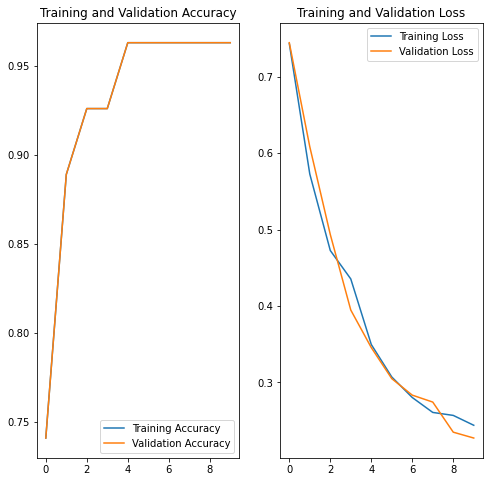

In [85]:
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_correct_list, label='Training Accuracy')
plt.plot(epochs_range, test_correct_list, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss_list, label='Training Loss')
plt.plot(epochs_range, test_loss_list, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Task 4. Heart Disease Prediction Using an ANN

### Preprocessing the dataset

In [86]:
import pandas as pd
from torch.utils.data import Dataset,DataLoader,TensorDataset

In [87]:
pd_ori = pd.read_csv('/Users/mucheng/Desktop/heart.csv')
pd_ori.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [88]:
pd_ori.shape

(918, 12)

In [90]:
from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

In [91]:
cat_si_step = ('si', SimpleImputer(strategy='constant', fill_value=-99))
cat_ohe_step = ('ohe', OrdinalEncoder()) #离散数据整数化处理
cat_steps = [cat_si_step, cat_ohe_step]

cat_pipe = Pipeline(cat_steps)
cat_cols = ['Sex','ChestPainType','RestingECG','ExerciseAngina'
,'ST_Slope']
cat_transformers = [('cat', cat_pipe, cat_cols)]

ct = ColumnTransformer(transformers=cat_transformers)

In [92]:
X_kdd_transformed = ct.fit_transform(pd_ori)
X_kdd_transformed.shape

(918, 5)

In [93]:
ct

ColumnTransformer(transformers=[('cat',
                                 Pipeline(steps=[('si',
                                                  SimpleImputer(fill_value=-99,
                                                                strategy='constant')),
                                                 ('ohe', OrdinalEncoder())]),
                                 ['Sex', 'ChestPainType', 'RestingECG',
                                  'ExerciseAngina', 'ST_Slope'])])

In [94]:
ct.named_transformers_['cat'].named_steps['ohe'].categories_

[array(['F', 'M'], dtype=object),
 array(['ASY', 'ATA', 'NAP', 'TA'], dtype=object),
 array(['LVH', 'Normal', 'ST'], dtype=object),
 array(['N', 'Y'], dtype=object),
 array(['Down', 'Flat', 'Up'], dtype=object)]

In [95]:
X_kdd_transformed[:5]

array([[1., 1., 1., 0., 2.],
       [0., 2., 1., 0., 1.],
       [1., 1., 2., 0., 2.],
       [0., 0., 1., 1., 1.],
       [1., 2., 1., 0., 2.]])

In [96]:
pd_ori[cat_cols][:5]

,Sex,ChestPainType,RestingECG,ExerciseAngina,ST_Slope
0,M,ATA,Normal,N,Up
1,F,NAP,Normal,N,Flat
2,M,ATA,ST,N,Up
3,F,ASY,Normal,Y,Flat
4,M,NAP,Normal,N,Up


In [97]:
X_kdd_transformed.shape


(918, 5)

In [98]:
pd_ori.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [99]:
pd_ori.columns

Index(['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope',
       'HeartDisease'],
      dtype='object')

In [100]:
num_cols = ['Age', 'RestingBP', 'Cholesterol','FastingBS','MaxHR', 'Oldpeak']

In [101]:

num_si_step = ('si', SimpleImputer(strategy='median'))
num_ss_step = ('ss', StandardScaler()) #均值-标准差归一化
num_steps = [num_si_step, num_ss_step]

num_pipe = Pipeline(num_steps)
num_transformers = [('num', num_pipe, num_cols)]

ct = ColumnTransformer(transformers=num_transformers)

X_num_transformed = ct.fit_transform(pd_ori)
X_num_transformed.shape

(918, 6)

In [102]:
X_num_transformed[:5]

array([[-1.4331398 ,  0.41090889,  0.82507026, -0.55134134,  1.38292822,
        -0.83243239],
       [-0.47848359,  1.49175234, -0.17196105, -0.55134134,  0.75415714,
         0.10566353],
       [-1.75135854, -0.12951283,  0.7701878 , -0.55134134, -1.52513802,
        -0.83243239],
       [-0.5845565 ,  0.30282455,  0.13903954, -0.55134134, -1.13215609,
         0.57471149],
       [ 0.05188098,  0.95133062, -0.0347549 , -0.55134134, -0.5819814 ,
        -0.83243239]])

In [103]:
transformers = [('cat', cat_pipe, cat_cols),
                ('num', num_pipe, num_cols)]

ct = ColumnTransformer(transformers=transformers)

X_strct = ct.fit_transform(pd_ori)
X_strct.shape

(918, 11)

In [104]:
dim_num = X_strct.shape[-1]
dim_num

11

In [105]:
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
labels_ori_list =pd_ori['HeartDisease'].values
label_list = label_encoder.fit_transform(labels_ori_list)

label_list[:10],pd_ori['HeartDisease'].values[:10]

(array([0, 1, 0, 1, 0, 0, 0, 0, 1, 0]), array([0, 1, 0, 1, 0, 0, 0, 0, 1, 0]))

In [106]:
X.shape

torch.Size([64, 1, 28, 28])

### Dataset and Dataloader

In [107]:
ds_train = TensorDataset(torch.tensor(X_strct[:700]).float(),torch.tensor(label_list[:700]))
ds_test = TensorDataset(torch.tensor(X_strct[700:]).float(),torch.tensor(label_list[700:]))

dl_train = DataLoader(ds_train,shuffle = True, batch_size = 8)
dl_test = DataLoader(ds_test,shuffle = False, batch_size = 8)

In [108]:
# 测试数据管道
for features,labels in dl_train:
    print(features,labels)
    break

tensor([[ 1.0000,  1.0000,  1.0000,  0.0000,  2.0000, -0.5846,  0.4109,  0.3586,
         -0.5513, -0.7392, -0.8324],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  2.0000,  0.3701, -0.2376,  0.9531,
         -0.5513,  0.8721, -0.8324],
        [ 1.0000,  0.0000,  1.0000,  1.0000,  1.0000, -0.3724, -0.1295,  0.3128,
         -0.5513, -0.6213,  1.0438],
        [ 1.0000,  1.0000,  1.0000,  0.0000,  2.0000, -0.4785, -1.7508,  0.4958,
         -0.5513,  1.4615, -0.8324],
        [ 1.0000,  0.0000,  0.0000,  1.0000,  1.0000,  0.7944,  0.3028, -0.3000,
         -0.5513, -0.4641,  2.5447],
        [ 0.0000,  3.0000,  2.0000,  0.0000,  2.0000, -1.9635, -0.6699, -0.3549,
         -0.5513,  1.8938, -0.8324],
        [ 0.0000,  1.0000,  1.0000,  0.0000,  2.0000, -0.9028,  2.5726,  0.8800,
         -0.5513,  1.6973, -0.8324],
        [ 1.0000,  0.0000,  2.0000,  1.0000,  1.0000,  0.6883,  1.4918, -1.8184,
         -0.5513, -1.4858, -0.3634]]) tensor([0, 0, 1, 0, 1, 0, 0, 1])


## Building a Simple NN


In [109]:
import torch.nn as nn
import torch.nn.functional as F

class NetHeartDnn(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(11, 50)
        self.fc2 = nn.Linear(50, 20)
        self.fc3 = nn.Linear(20, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net_heart_dnn = NetHeartDnn().to(device)
net_heart_dnn(features).shape

torch.Size([8, 2])

In [110]:
net_heart_dnn

NetHeartDnn(
  (fc1): Linear(in_features=11, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=2, bias=True)
)

### Building a CNN Model

In [111]:
import torch.nn as nn
import torch.nn.functional as F

class NetHeartCnn(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(5, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(11, 50)
        self.fc2 = nn.Linear(9, 20)
        self.fc3 = nn.Linear(20, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = x.view(-1,5,10)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.flatten(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net_heart_cnn = NetHeartCnn().to(device)
net_heart_cnn(features).shape

torch.Size([8, 2])

In [112]:
net_heart_cnn

NetHeartCnn(
  (conv1): Conv1d(5, 6, kernel_size=(5,), stride=(1,))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=11, out_features=50, bias=True)
  (fc2): Linear(in_features=9, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=2, bias=True)
)

### Calculating Loss and Optimize the Model

The following demonstration will show the evaluations of dnn Model as the cnn Model is commented out for better demonstration purpose


In [113]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net_heart_dnn.parameters(), lr=1e-3)
# optimizer = torch.optim.Adam(net_heart_cnn.parameters(), lr=1e-3)

### Building the Training and Testing Loops


In [114]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [115]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return correct,test_loss

### Accuracy Scores and Evaluations



In [116]:
epochs = 10
train_correct_list = []
train_loss_list = []
test_correct_list = []
test_loss_list = []
# model_eg = net_heart_cnn
model_eg = net_heart_dnn
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(dl_train, model_eg, loss_fn, optimizer)
    train_correct,train_loss = test(dl_train, model_eg, loss_fn)
    test_correct,test_loss = test(dl_test, model_eg, loss_fn)
    train_correct_list.append(train_correct)
    train_loss_list.append(train_loss)
    test_correct_list.append(test_correct)
    test_loss_list.append(test_loss)
print("Done!")

Epoch 1
-------------------------------
loss: 0.779542  [    0/  700]
Test Error: 
 Accuracy: 85.0%, Avg loss: 0.413730 

Test Error: 
 Accuracy: 80.3%, Avg loss: 0.490660 

Epoch 2
-------------------------------
loss: 0.414408  [    0/  700]
Test Error: 
 Accuracy: 86.7%, Avg loss: 0.336359 

Test Error: 
 Accuracy: 79.4%, Avg loss: 0.474799 

Epoch 3
-------------------------------
loss: 0.098768  [    0/  700]
Test Error: 
 Accuracy: 87.3%, Avg loss: 0.313143 

Test Error: 
 Accuracy: 79.8%, Avg loss: 0.490557 

Epoch 4
-------------------------------
loss: 0.388225  [    0/  700]
Test Error: 
 Accuracy: 89.6%, Avg loss: 0.297231 

Test Error: 
 Accuracy: 78.9%, Avg loss: 0.477025 

Epoch 5
-------------------------------
loss: 0.337300  [    0/  700]
Test Error: 
 Accuracy: 89.3%, Avg loss: 0.283728 

Test Error: 
 Accuracy: 78.0%, Avg loss: 0.508173 

Epoch 6
-------------------------------
loss: 0.298900  [    0/  700]
Test Error: 
 Accuracy: 89.9%, Avg loss: 0.278001 

Test Err

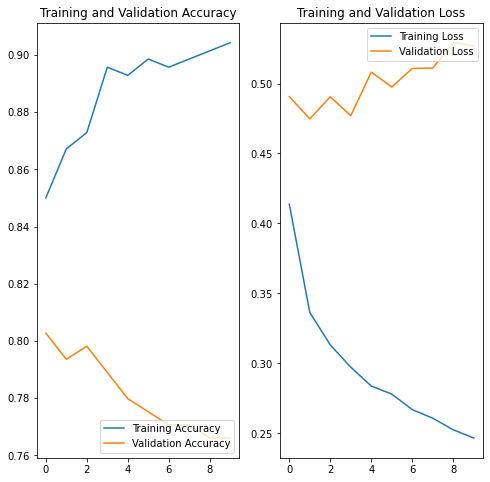

In [117]:
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_correct_list, label='Training Accuracy')
plt.plot(epochs_range, test_correct_list, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss_list, label='Training Loss')
plt.plot(epochs_range, test_loss_list, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## CNN Demonstration

In [118]:
loss_fn = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(net_heart_dnn.parameters(), lr=1e-3)
optimizer = torch.optim.Adam(net_heart_cnn.parameters(), lr=1e-3)

In [119]:
epochs = 10
train_correct_list = []
train_loss_list = []
test_correct_list = []
test_loss_list = []
model_eg = net_heart_cnn
# model_eg = net_heart_dnn
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(dl_train, model_eg, loss_fn, optimizer)
    train_correct,train_loss = test(dl_train, model_eg, loss_fn)
    test_correct,test_loss = test(dl_test, model_eg, loss_fn)
    train_correct_list.append(train_correct)
    train_loss_list.append(train_loss)
    test_correct_list.append(test_correct)
    test_loss_list.append(test_loss)
print("Done!")

Epoch 1
-------------------------------
loss: 0.700072  [    0/  700]
Test Error: 
 Accuracy: 84.0%, Avg loss: 0.507344 

Test Error: 
 Accuracy: 79.8%, Avg loss: 0.543642 

Epoch 2
-------------------------------
loss: 0.470712  [    0/  700]
Test Error: 
 Accuracy: 85.6%, Avg loss: 0.380255 

Test Error: 
 Accuracy: 79.8%, Avg loss: 0.468087 

Epoch 3
-------------------------------
loss: 0.372330  [    0/  700]
Test Error: 
 Accuracy: 87.0%, Avg loss: 0.350455 

Test Error: 
 Accuracy: 81.2%, Avg loss: 0.458764 

Epoch 4
-------------------------------
loss: 0.278599  [    0/  700]
Test Error: 
 Accuracy: 87.9%, Avg loss: 0.333060 

Test Error: 
 Accuracy: 81.7%, Avg loss: 0.458835 

Epoch 5
-------------------------------
loss: 0.562446  [    0/  700]
Test Error: 
 Accuracy: 87.9%, Avg loss: 0.317342 

Test Error: 
 Accuracy: 80.3%, Avg loss: 0.467540 

Epoch 6
-------------------------------
loss: 0.447451  [    0/  700]
Test Error: 
 Accuracy: 89.1%, Avg loss: 0.308947 

Test Err

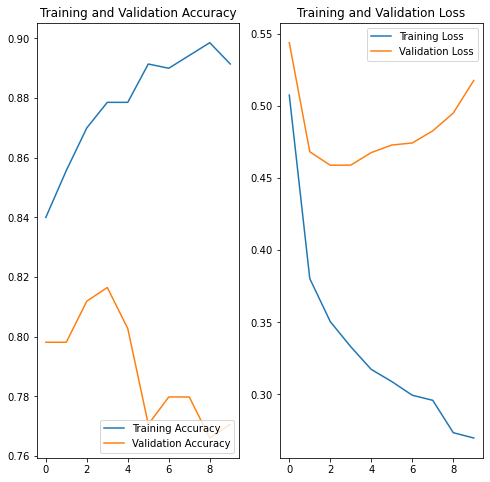

In [120]:
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_correct_list, label='Training Accuracy')
plt.plot(epochs_range, test_correct_list, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss_list, label='Training Loss')
plt.plot(epochs_range, test_loss_list, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()